In [1]:
import glob
import os
import pickle
import time

import matplotlib.pyplot as plt
import numpy as np
import zarr
from matplotlib.colors import hsv_to_rgb
from waveorder.io.reader import WaveorderReader
from waveorder.io.writer import WaveorderWriter

import waveorder as wo

%matplotlib inline
plt.style.use(["dark_background"])  # Plotting option for dark background

In [2]:
n_media = 1.33  # refractive index of the immersed media for objective (oil: 1.512, water: 1.33, air: 1)
lambda_illu = 0.77  # illumination wavelength (um)
mag = 60  # magnification of the microscope
NA_obj = 1.2  # detection NA of the objective
NA_illu = 1.2  # illumination NA of the condenser
N_defocus = 40  # number of defocus images
N_channel = 4  # number of Polscope channels
N_pattern = 9
z_step = 0.4  # z_step of the stack
z_defocus = (np.r_[:N_defocus] - 0) * z_step
ps = 3.45 * 2 / mag  # effective pixel size at the sample plane (cam pix/mag in um)
cali = False  # correction for S1/S2 Polscope reconstruction (does not affect phase)
bg_option = "global"  # background correction method for Polscope recon (does not affect phase)
pad_z = 5  # padding along z to avoid periodic artifacts in reconstructions

data_path = "/gpfs/CompMicro/rawdata/falcon/LiHao/20210317_Falcon_3D_PTI_realign_H_and_E_770nm/smooth_muscle_2/data/"  # path to data
calibration_path = (
    "/gpfs/CompMicro/rawdata/falcon/LiHao/20210317_Falcon_3D_PTI_realign_H_and_E_770nm/"  # path to calibration data
)
bg_path = "/gpfs/CompMicro/rawdata/falcon/LiHao/20210317_Falcon_3D_PTI_realign_H_and_E_770nm/smooth_muscle_1/bg/"  # path to background images
output_path = "Full_FOV_process_test_new_pipeline"  # output image path
use_gpu = True
gpu_id = 0

reg_inc = np.array([2, 2, 20, 20, 80, 80, 80]) * 1  # regularization for 3D orientation recon
reg_ret_pr = 1e-2  # principle retardance regularization

In [3]:
filedir = data_path + "*img*.tif"
filedir_cali = calibration_path + "Calibration/" + "img*.tif"
filedir_bg = bg_path + "img*.tif"
files = sorted(glob.glob(filedir), key=wo.numericalSort)
files_cali = sorted(glob.glob(filedir_cali), key=wo.numericalSort)
files_bg = sorted(glob.glob(filedir_bg), key=wo.numericalSort)

### Calibration

In [4]:
# Load calibration

gamma_comp = 1  # gamma compensation
N_cali = 360  # number of calibration images

f = open("cali_images.pckl", "rb")
I_cali_mean = pickle.load(f)
f.close()

Calibrated source field:
[[ 0.6375+0.j    ]
 [-0.1235+0.7605j]]
Calibrated instrument matrix:
[[ 0.2531  0.2403  0.    ]
 [ 0.2545  0.0075  0.2031]
 [ 0.2418 -0.242   0.0003]
 [ 0.2506 -0.0058 -0.2034]]


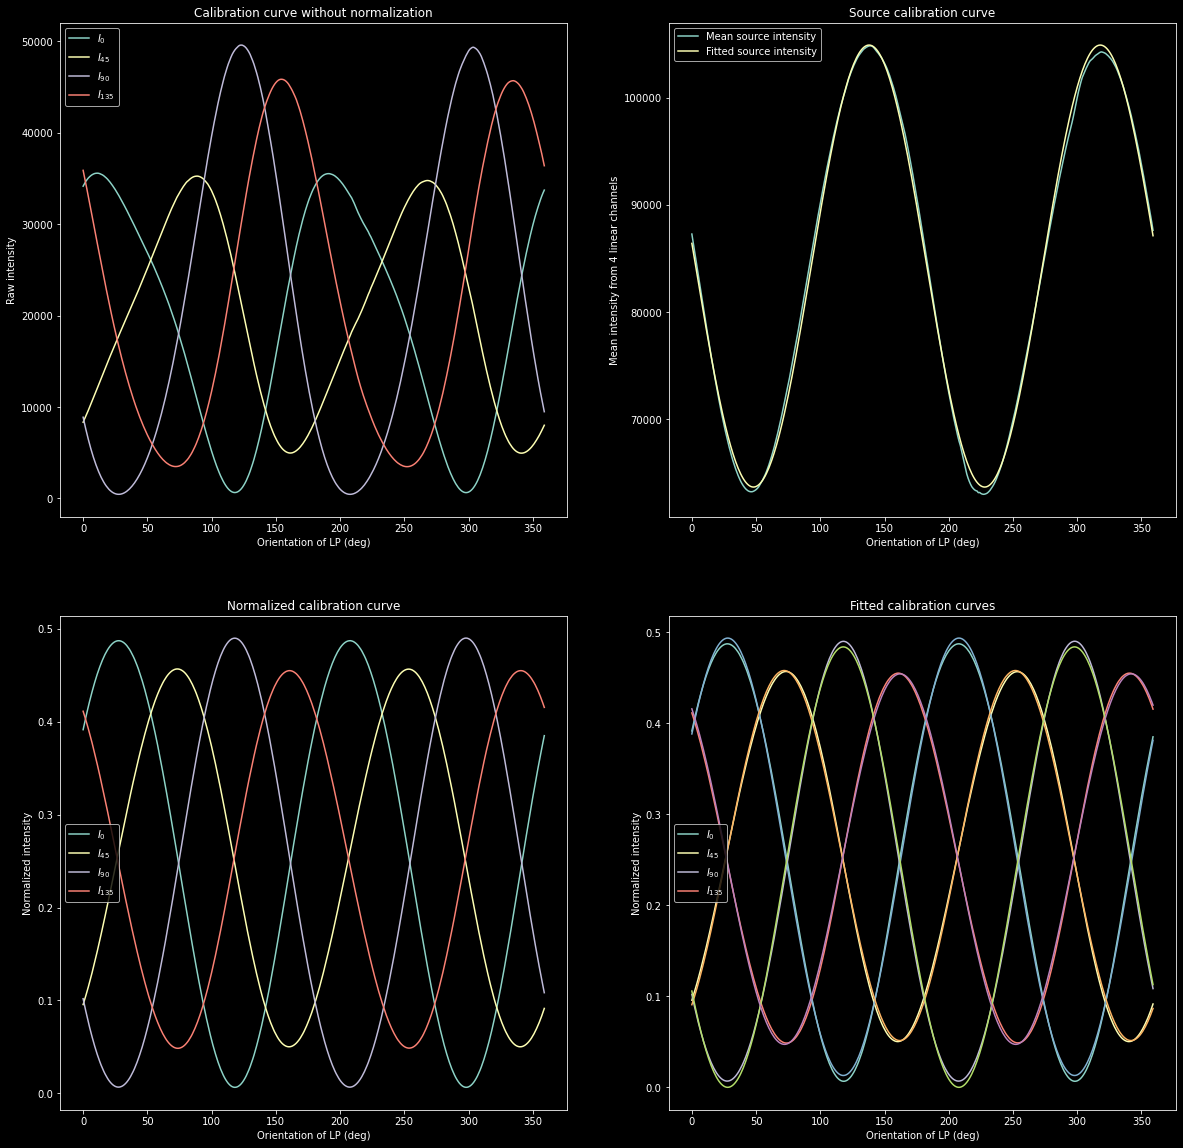

In [5]:
E_in, A_matrix, I_cali_mean = wo.instrument_matrix_and_source_calibration(I_cali_mean, handedness="RCP")

### Creating processing list for sub-FOV 

In [6]:
N_full = 1024
M_full = 1224
overlapping_range = [62, 100]
max_image_size = [400, 400]

N_edge, N_space, M_space = wo.generate_FOV_splitting_parameters((N_full, M_full), overlapping_range, max_image_size)

Optimal number of overlapping is 64 pixels
The corresponding maximal N_space is 320 pixels
The corresponding maximal M_space is 290 pixels


In [7]:
# Create sub-FOV list

Ns = N_space + N_edge
Ms = M_space + N_edge

ns, ms = wo.generate_sub_FOV_coordinates((N_full, M_full), (N_space, M_space), (N_edge, N_edge))

os.system("mkdir " + output_path)

Last pixel in (y,x) dimension processed is (1024, 1224)


0

### Initialize the processing (Source, OTF, ...)

In [8]:
# DPC + BF illumination

xx, yy, fxx, fyy = wo.gen_coordinate((Ns, Ms), ps)


rotation_angle = [180 - 22.5, 225 - 22.5, 270 - 22.5, 315 - 22.5, 0 - 22.5, 45 - 22.5, 90 - 22.5, 135 - 22.5]

sector_angle = 45

Source_BF = wo.gen_Pupil(fxx, fyy, NA_obj / n_media / 2, lambda_illu / n_media)
Source = wo.gen_sector_Pupil(fxx, fyy, NA_obj / n_media, lambda_illu / n_media, sector_angle, rotation_angle)
Source.append(Source_BF)
Source = np.array(Source)


Source_PolState = np.zeros((len(Source), 2), complex)


for i in range(len(Source)):
    Source_PolState[i, 0] = E_in[0]
    Source_PolState[i, 1] = E_in[1]


# Reconstruct parameters

setup = wo.waveorder_microscopy(
    (Ns, Ms),
    lambda_illu,
    ps,
    NA_obj,
    NA_illu,
    z_defocus,
    n_media=n_media,
    cali=cali,
    bg_option=bg_option,
    A_matrix=A_matrix,
    phase_deconv="3D",
    inc_recon="3D",
    illu_mode="Arbitrary",
    Source=Source,
    Source_PolState=Source_PolState,
    use_gpu=use_gpu,
    gpu_id=gpu_id,
)

In [9]:
import gc

import cupy as cp

gc.collect()
cp.get_default_memory_pool().free_all_blocks()

### Data loading

In [10]:
# Loading full FOV data
I_bg_full = np.zeros((N_channel, N_pattern + 1, N_full, M_full))
I_meas_full = np.zeros((N_channel, N_pattern + 1, N_full, M_full, N_defocus))
start_idx = [(1, 1), (1, 0), (0, 0), (0, 1)]

for i in range(N_pattern + 1):
    I_bg_temp = (plt.imread(files_bg[i]).astype("float64")) ** gamma_comp
    for ll in range(4):
        I_bg_full[ll, i, :, :] = I_bg_temp[start_idx[ll][0] :: 2, start_idx[ll][1] :: 2]
    for p in range(N_defocus):
        idx = N_defocus * i + p
        I_meas_temp = (plt.imread(files[idx]).astype("float64")) ** gamma_comp
        for ll in range(4):
            I_meas_full[ll, i, :, :, p] = I_meas_temp[start_idx[ll][0] :: 2, start_idx[ll][1] :: 2]

I_meas_minus_leak = np.maximum(0, I_meas_full[:, :9] - (I_meas_full[:, -1])[:, np.newaxis, :, :, :])
I_bg_minus_leak = np.maximum(0, I_bg_full[:, :9] - (I_bg_full[:, -1])[:, np.newaxis, :, :])

### Writer setup

In [12]:
PTI_file_name = "PTI_subFOVs.zarr"
writer = WaveorderWriter(output_path, hcs=False, hcs_meta=None, verbose=True)
writer.create_zarr_root(PTI_file_name)

data_shape = (1, 9, N_defocus, int(Ns), int(Ms))
chunk_size = (1, 1, 1, int(Ns), int(Ms))
chan_names = [
    "f_tensor0r",
    "f_tensor0i",
    "f_tensor1c",
    "f_tensor1s",
    "f_tensor2c",
    "f_tensor2s",
    "f_tensor3",
    "mat_map0",
    "mat_map1",
]

# append stitching parameters
row_list = (ns // N_space).astype("int")
column_list = (ms // M_space).astype("int")
PTI_file = zarr.open(os.path.join(output_path, PTI_file_name), mode="a")
PTI_file.create_dataset("row_list", data=row_list)
PTI_file.create_dataset("column_list", data=column_list)
PTI_file.create_dataset("overlap", data=N_edge)

Creating new zarr store at Full_FOV_process_test_new_pipeline/PTI_subFOVs.zarr


<zarr.core.Array '/overlap' () int64>

### Patch-wise processing

In [13]:
t0 = time.time()

for ll in range(len(ns)):
    position = ll
    writer.init_array(position, data_shape, chunk_size, chan_names, position_name=None, overwrite=True)
    n_start = [int(ns[ll]), int(ms[ll])]

    # Compute background-removed Stokes vectors
    S_image_recon = setup.Stokes_recon(
        I_meas_minus_leak[:, :, n_start[0] : n_start[0] + Ns, n_start[1] : n_start[1] + Ms, ::-1]
    )
    S_bg_recon = setup.Stokes_recon(I_bg_minus_leak[:, :, n_start[0] : n_start[0] + Ns, n_start[1] : n_start[1] + Ms])

    S_image_tm = np.zeros_like(S_image_recon)
    S_image_tm[0] = S_image_recon[0] / S_bg_recon[0, :, :, :, np.newaxis] - 1
    S_image_tm[1] = (
        S_image_recon[1] / S_bg_recon[0, :, :, :, np.newaxis]
        - S_bg_recon[1, :, :, :, np.newaxis] * S_image_recon[0] / S_bg_recon[0, :, :, :, np.newaxis] ** 2
    )
    S_image_tm[2] = (
        S_image_recon[2] / S_bg_recon[0, :, :, :, np.newaxis]
        - S_bg_recon[2, :, :, :, np.newaxis] * S_image_recon[0] / S_bg_recon[0, :, :, :, np.newaxis] ** 2
    )

    f_tensor = setup.scattering_potential_tensor_recon_3D_vec(S_image_tm, reg_inc=reg_inc, cupy_det=True)
    _, _, _, mat_map = setup.scattering_potential_tensor_to_3D_orientation(
        f_tensor,
        S_image_tm,
        material_type="unknown",
        verbose=False,
        reg_ret_pr=reg_ret_pr,
        itr=60,
        step_size=0.1,
        fast_gpu_mode=True,
    )

    PTI_array = np.transpose(
        np.concatenate((f_tensor, mat_map), axis=0)[np.newaxis, ...], (0, 1, 4, 2, 3)
    )  # dimension (T, C, Z, Y, X)
    writer.write(PTI_array, p=ll)
    print("Finish process at (y, x) = (%d, %d), elapsed time: %.2f" % (ns[ll], ms[ll], time.time() - t0))

Creating and opening subgroup Row_0/Col_0/Pos_000
Finished preprocess, elapsed time: 30.59
Finished reconstruction, elapsed time: 31.89
Finish optic sign estimation, elapsed time: 109.87
Opening subgroup Row_0/Col_0/Pos_000
Finish process at (y, x) = (0, 0), elapsed time: 168.46
Creating and opening subgroup Row_0/Col_1/Pos_001
Finished preprocess, elapsed time: 27.95
Finished reconstruction, elapsed time: 28.56
Finish optic sign estimation, elapsed time: 100.75
Opening subgroup Row_0/Col_1/Pos_001
Finish process at (y, x) = (0, 290), elapsed time: 323.92
Creating and opening subgroup Row_0/Col_2/Pos_002
Finished preprocess, elapsed time: 27.67
Finished reconstruction, elapsed time: 28.27
Finish optic sign estimation, elapsed time: 100.42
Opening subgroup Row_0/Col_2/Pos_002
Finish process at (y, x) = (0, 580), elapsed time: 478.52
Creating and opening subgroup Row_0/Col_3/Pos_003
Finished preprocess, elapsed time: 27.62
Finished reconstruction, elapsed time: 28.23
Finish optic sign es

In [14]:
import gc

import cupy as cp

gc.collect()
cp.get_default_memory_pool().free_all_blocks()

### Image stitching

In [15]:
# save stitched results

PTI_file_name = "PTI_subFOVs.zarr"

reader = WaveorderReader(os.path.join(output_path, PTI_file_name), "zarr")
PTI_file = zarr.open(os.path.join(output_path, PTI_file_name), mode="a")

coord_list = (np.array(PTI_file.row_list), np.array(PTI_file.column_list))
overlap = (int(np.array(PTI_file.overlap)), int(np.array(PTI_file.overlap)))
file_loading_func = lambda x: np.transpose(reader.get_array(x), (3, 4, 0, 1, 2))

img_normalized, ref_stitch = wo.image_stitching(
    coord_list, overlap, file_loading_func, gen_ref_map=True, ref_stitch=None
)

Processed positions (1 / 12), elapsed time: 3.02
Processed positions (2 / 12), elapsed time: 5.03
Processed positions (3 / 12), elapsed time: 6.86
Processed positions (4 / 12), elapsed time: 8.77
Processed positions (5 / 12), elapsed time: 10.38
Processed positions (6 / 12), elapsed time: 12.17
Processed positions (7 / 12), elapsed time: 13.89
Processed positions (8 / 12), elapsed time: 15.49
Processed positions (9 / 12), elapsed time: 17.13
Processed positions (10 / 12), elapsed time: 18.86
Processed positions (11 / 12), elapsed time: 20.61
Processed positions (12 / 12), elapsed time: 22.16


In [16]:
writer = WaveorderWriter(output_path, hcs=False, hcs_meta=None, verbose=True)
writer.create_zarr_root("PTI_stitched.zarr")
chan_names = [
    "f_tensor0r",
    "f_tensor0i",
    "f_tensor1c",
    "f_tensor1s",
    "f_tensor2c",
    "f_tensor2s",
    "f_tensor3",
    "mat_map0",
    "mat_map1",
]

PTI_array_stitched = np.transpose(img_normalized, (2, 3, 4, 0, 1))
position = 0
data_shape_stitched = PTI_array_stitched.shape
chunk_size_stitched = (1, 1, 1) + PTI_array_stitched.shape[3:]
writer.init_array(
    position, data_shape_stitched, chunk_size_stitched, chan_names, position_name="Stitched_f_tensor", overwrite=True
)
writer.write(PTI_array_stitched, p=position)

Creating new zarr store at Full_FOV_process_test_new_pipeline/PTI_stitched.zarr
Creating and opening subgroup Row_0/Col_0/Stitched_f_tensor
Opening subgroup Row_0/Col_0/Stitched_f_tensor


### Data analysis with stitched images

In [4]:
# load the stitched scattering potential tensor

Nc = 1024
Mc = 1224
n_start = [0, 0]


PTI_file_name = "PTI_stitched.zarr"
reader = WaveorderReader(os.path.join(output_path, PTI_file_name), "zarr")
PTI_array_stitched = np.transpose(
    np.squeeze(np.array(reader.get_zarr(0)[..., n_start[0] : n_start[0] + Nc, n_start[1] : n_start[1] + Mc])),
    (0, 2, 3, 1),
)
f_tensor = PTI_array_stitched[:7]
mat_map = PTI_array_stitched[7:]

In [5]:
# compute the physical properties from the scattering potential tensor

retardance_pr_p, azimuth_p, theta_p = wo.scattering_potential_tensor_to_3D_orientation_PN(
    f_tensor, material_type="positive", reg_ret_pr=reg_ret_pr
)
retardance_pr_n, azimuth_n, theta_n = wo.scattering_potential_tensor_to_3D_orientation_PN(
    f_tensor, material_type="negative", reg_ret_pr=reg_ret_pr
)
retardance_pr = np.array([retardance_pr_p, retardance_pr_n])
azimuth = np.array([azimuth_p, azimuth_n])
theta = np.array([theta_p, theta_n])

p_mat_map = wo.optic_sign_probability(mat_map, mat_map_thres=0.07)
phase = wo.phase_inc_correction(f_tensor[0], retardance_pr[0], theta[0])
phase_PT, absorption_PT, retardance_pr_PT = [
    wo.unit_conversion_from_scattering_potential_to_permittivity(
        SP_array, lambda_illu, n_media=n_media, imaging_mode="3D"
    )
    for SP_array in [phase, f_tensor[1].copy(), retardance_pr]
]
retardance_pr_PT = np.array(
    [((-1) ** i) * wo.wavelet_softThreshold(((-1) ** i) * retardance_pr_PT[i], "db8", 0.001, level=1) for i in range(2)]
)

In [6]:
# save results to zarr array
writer = WaveorderWriter(output_path, hcs=False, hcs_meta=None, verbose=True)
writer.create_zarr_root("PTI_physical.zarr")

position = 0
chan_names_phys = ["Phase3D", "Retardance3D", "Orientation", "Inclination", "Optic_sign"]
phys_data_array = np.transpose(
    np.array([phase_PT, np.abs(retardance_pr_PT[0]), azimuth[0], theta[0], p_mat_map]), (0, 3, 1, 2)
)[np.newaxis, ...]
data_shape_phys = phys_data_array.shape
chunk_size_phys = (1, 1, 1) + phys_data_array.shape[3:]
dtype = "float32"
writer.init_array(
    position,
    data_shape_phys,
    chunk_size_phys,
    chan_names_phys,
    dtype,
    position_name="Stitched_physical",
    overwrite=True,
)
writer.write(phys_data_array, p=position)

Creating new zarr store at Full_FOV_process_test_new_pipeline/PTI_physical.zarr
Creating and opening subgroup Row_0/Col_0/Stitched_physical
Opening subgroup Row_0/Col_0/Stitched_physical


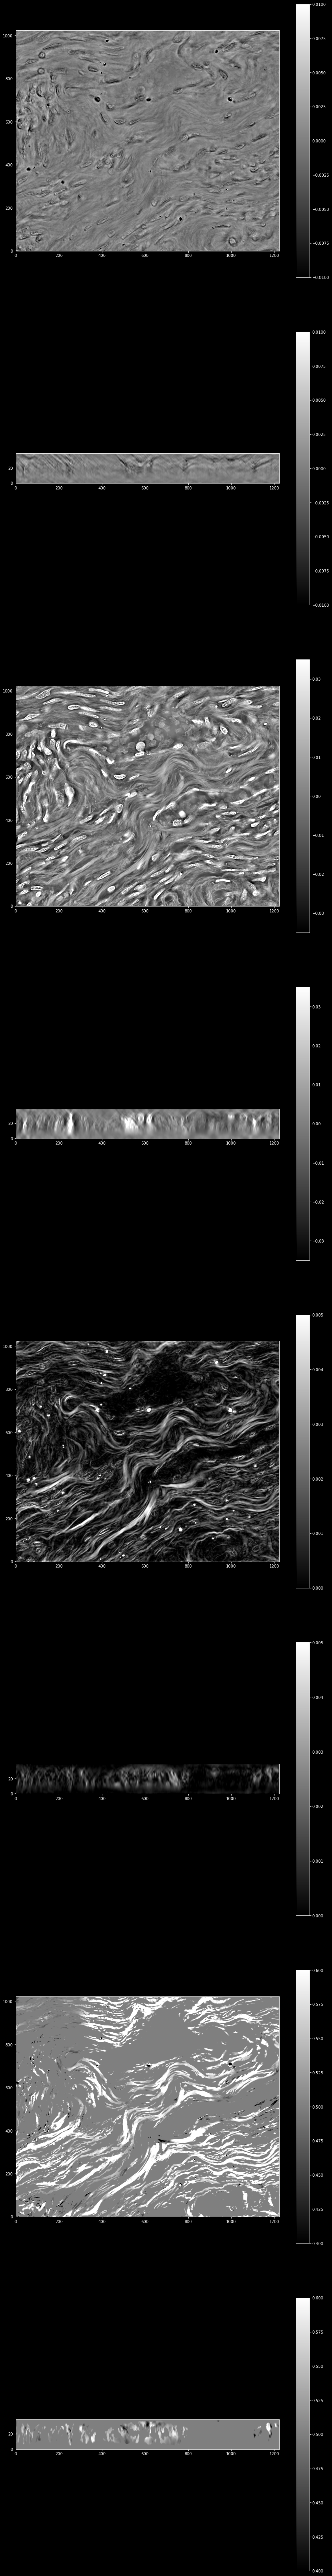

In [7]:
# Visualize the results

z_layer = 20
y_layer = 512

phase_min = -0.035
phase_max = 0.035
abs_min = -0.01
abs_max = 0.01
ret_min = 0
ret_max = 0.005
p_min = 0.4
p_max = 0.6


fig, ax = plt.subplots(8, 1, figsize=(15, 120))
sub_ax = ax[0].imshow(absorption_PT[:, :, z_layer], cmap="gray", origin="lower", vmin=abs_min, vmax=abs_max)
plt.colorbar(sub_ax, ax=ax[0])
sub_ax = ax[1].imshow(
    np.transpose(absorption_PT[y_layer, :, :]),
    cmap="gray",
    origin="lower",
    vmin=abs_min,
    vmax=abs_max,
    aspect=z_step / ps,
)
plt.colorbar(sub_ax, ax=ax[1])
sub_ax = ax[2].imshow(phase_PT[:, :, z_layer], cmap="gray", origin="lower", vmin=phase_min, vmax=phase_max)
plt.colorbar(sub_ax, ax=ax[2])
sub_ax = ax[3].imshow(
    np.transpose(phase_PT[y_layer, :, :]),
    cmap="gray",
    origin="lower",
    vmin=phase_min,
    vmax=phase_max,
    aspect=z_step / ps,
)
plt.colorbar(sub_ax, ax=ax[3])
sub_ax = ax[4].imshow(
    np.abs(retardance_pr_PT[0, :, :, z_layer]), cmap="gray", origin="lower", vmin=ret_min, vmax=ret_max
)
plt.colorbar(sub_ax, ax=ax[4])
sub_ax = ax[5].imshow(
    np.transpose(np.abs(retardance_pr_PT[0, y_layer, :, :])),
    cmap="gray",
    origin="lower",
    vmin=ret_min,
    vmax=ret_max,
    aspect=z_step / ps,
)
plt.colorbar(sub_ax, ax=ax[5])
sub_ax = ax[6].imshow(p_mat_map[:, :, z_layer], cmap="gray", origin="lower", vmin=p_min, vmax=p_max)
plt.colorbar(sub_ax, ax=ax[6])
sub_ax = ax[7].imshow(
    np.transpose(p_mat_map[y_layer, :, :]), cmap="gray", origin="lower", vmin=p_min, vmax=p_max, aspect=z_step / ps
)
plt.colorbar(sub_ax, ax=ax[7])

### Render 3D orientation with 3D colorsphere (azimuth and inclination)

In [21]:
# create color-coded orientation images

ret_min_color = 0
ret_max_color = 0.003325

orientation_3D_image = np.transpose(
    np.array(
        [
            azimuth[0] / 2 / np.pi,
            theta[0],
            (np.clip(np.abs(retardance_pr_PT[0]), ret_min_color, ret_max_color) - ret_min_color)
            / (ret_max_color - ret_min_color),
        ]
    ),
    (3, 1, 2, 0),
)
orientation_3D_image_RGB = wo.orientation_3D_to_rgb(orientation_3D_image, interp_belt=20 / 180 * np.pi, sat_factor=1)

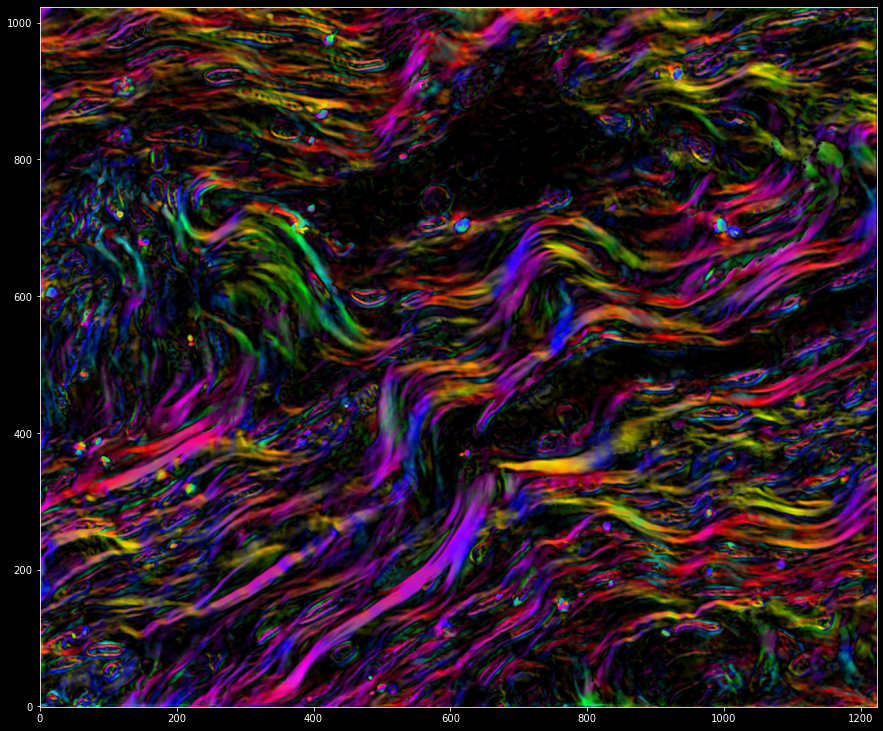

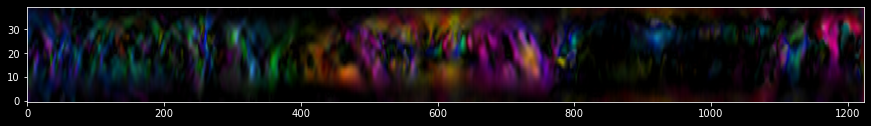

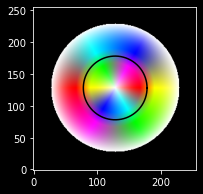

In [22]:
plt.figure(figsize=(15, 15))
plt.imshow(orientation_3D_image_RGB[z_layer], origin="lower")
plt.figure(figsize=(15, 15))
plt.imshow(orientation_3D_image_RGB[:, y_layer], origin="lower", aspect=z_step / ps)

# plot the top view of 3D orientation colorsphere
plt.figure(figsize=(3, 3))
wo.orientation_3D_colorwheel(wheelsize=256, circ_size=50, interp_belt=20 / 180 * np.pi, sat_factor=1)

### Render 3D orientation with 2 channels (in-plane orientation and out-of-plane tilt)

In [23]:
# in-plane orientation

I_hsv = np.transpose(
    np.array(
        [
            (azimuth[0]) % np.pi / np.pi,
            np.ones_like(retardance_pr_PT[0]),
            (np.clip(np.abs(retardance_pr_PT[0]), ret_min_color, ret_max_color) - ret_min_color)
            / (ret_max_color - ret_min_color),
        ]
    ),
    (3, 1, 2, 0),
)
in_plane_orientation = hsv_to_rgb(I_hsv.copy())

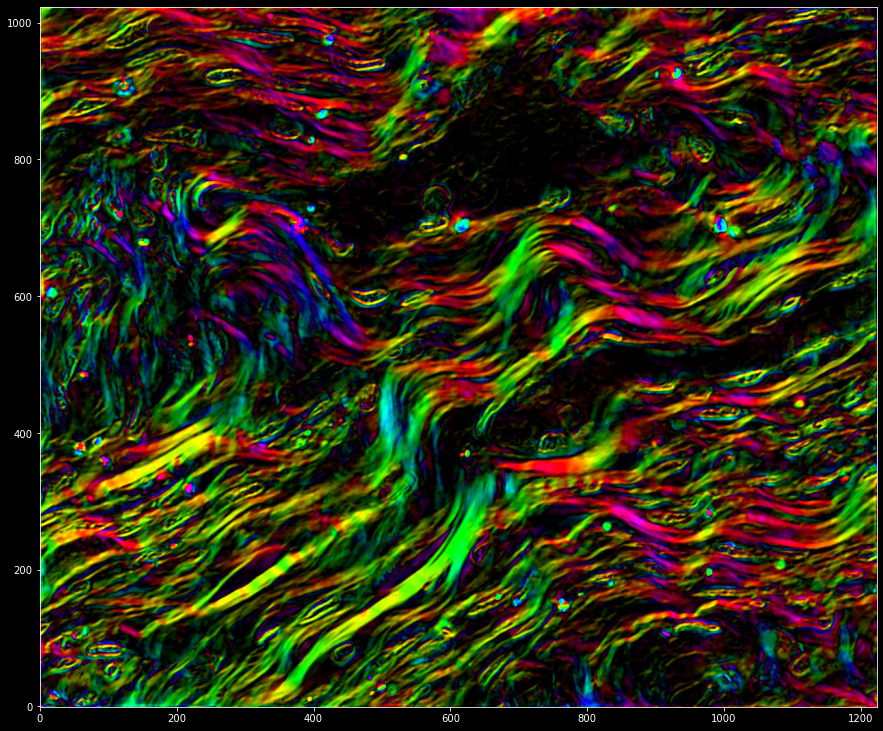

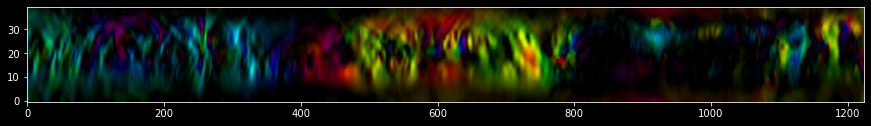

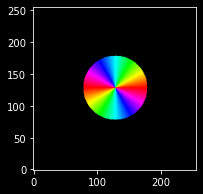

In [24]:
plt.figure(figsize=(15, 15))
plt.imshow(in_plane_orientation[z_layer], origin="lower")
plt.figure(figsize=(15, 15))
plt.imshow(in_plane_orientation[:, y_layer], origin="lower", aspect=z_step / ps)
plt.figure(figsize=(3, 3))
wo.orientation_2D_colorwheel()

In [25]:
# out-of-plane tilt

threshold_inc = np.pi / 90

I_hsv = np.transpose(
    np.array(
        [
            (-np.maximum(0, np.abs(theta[0] - np.pi / 2) - threshold_inc) + np.pi / 2 + threshold_inc) / np.pi,
            np.ones_like(retardance_pr_PT[0]),
            (np.clip(np.abs(retardance_pr_PT[0]), ret_min_color, ret_max_color) - ret_min_color)
            / (ret_max_color - ret_min_color),
        ]
    ),
    (3, 1, 2, 0),
)
out_of_plane_tilt = hsv_to_rgb(I_hsv.copy())

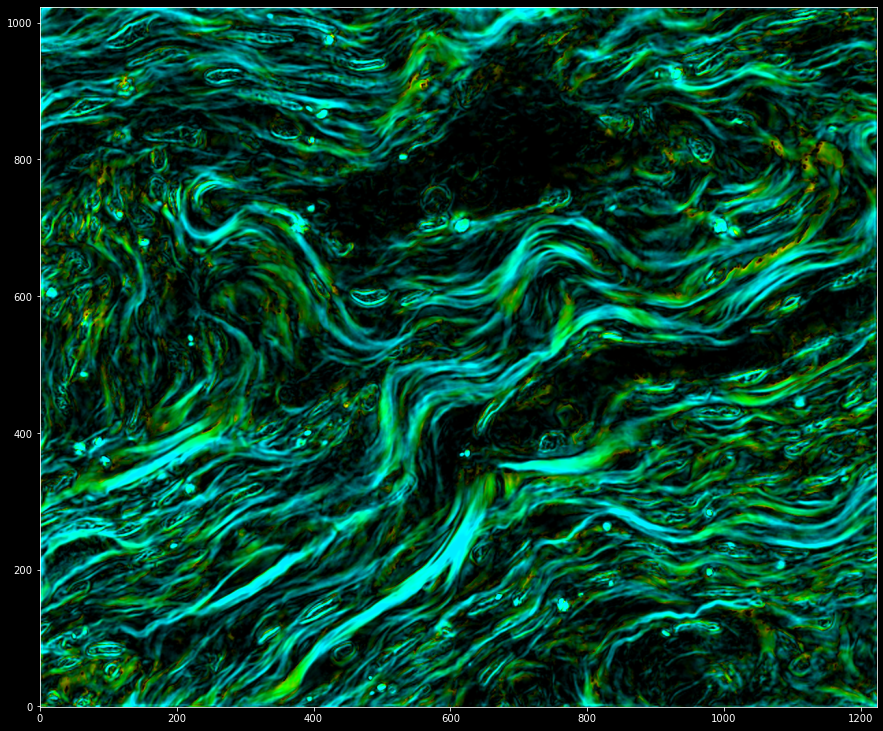

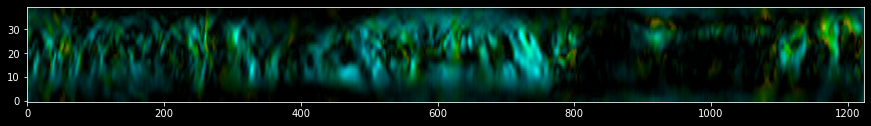

In [26]:
plt.figure(figsize=(15, 15))
plt.imshow(out_of_plane_tilt[z_layer], origin="lower")
plt.figure(figsize=(15, 15))
plt.imshow(out_of_plane_tilt[:, y_layer], origin="lower", aspect=z_step / ps)

## Sub-FOV analysis

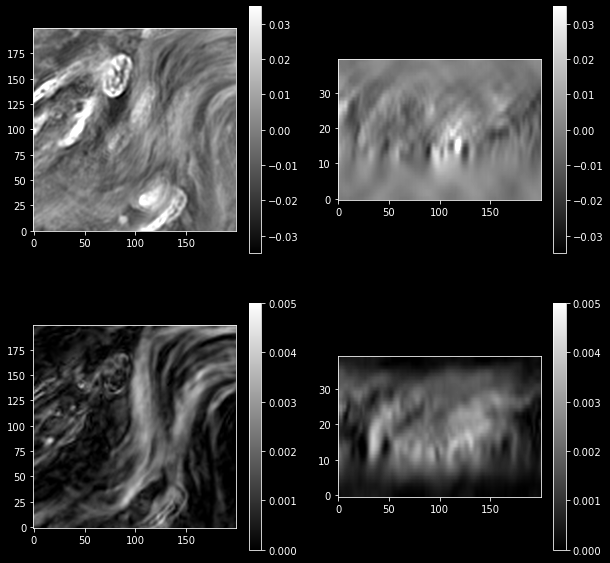

In [27]:
### FOV 1
idx_crop = [300, 400]
num_crop = [200, 200]

z_crop = [0, 40]
z_layer = 20


phase_crop = phase_PT[
    idx_crop[0] : idx_crop[0] + num_crop[0], idx_crop[1] : idx_crop[1] + num_crop[1], z_crop[0] : z_crop[1]
]
ret_crop = retardance_pr_PT[
    0, idx_crop[0] : idx_crop[0] + num_crop[0], idx_crop[1] : idx_crop[1] + num_crop[1], z_crop[0] : z_crop[1]
]
azimuth_crop = azimuth[
    0, idx_crop[0] : idx_crop[0] + num_crop[0], idx_crop[1] : idx_crop[1] + num_crop[1], z_crop[0] : z_crop[1]
]
theta_crop = theta[
    0, idx_crop[0] : idx_crop[0] + num_crop[0], idx_crop[1] : idx_crop[1] + num_crop[1], z_crop[0] : z_crop[1]
]
p_mat_map_crop = p_mat_map[
    idx_crop[0] : idx_crop[0] + num_crop[0], idx_crop[1] : idx_crop[1] + num_crop[1], z_crop[0] : z_crop[1]
]

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sub_ax = ax[0, 0].imshow(
    np.real(phase_crop[:, :, z_layer]), cmap="gray", origin="lower", vmin=phase_min, vmax=phase_max
)
plt.colorbar(sub_ax, ax=ax[0, 0])
sub_ax = ax[0, 1].imshow(
    np.transpose(phase_crop[:, 100, :]), cmap="gray", origin="lower", vmin=phase_min, vmax=phase_max, aspect=z_step / ps
)
plt.colorbar(sub_ax, ax=ax[0, 1])
sub_ax = ax[1, 0].imshow(np.real(ret_crop[:, :, z_layer]), cmap="gray", origin="lower", vmin=ret_min, vmax=ret_max)
plt.colorbar(sub_ax, ax=ax[1, 0])
sub_ax = ax[1, 1].imshow(
    np.transpose(ret_crop[:, 100, :]), cmap="gray", origin="lower", vmin=ret_min, vmax=ret_max, aspect=z_step / ps
)
plt.colorbar(sub_ax, ax=ax[1, 1])

(<Figure size 360x360 with 1 Axes>, <PolarAxesSubplot:>)

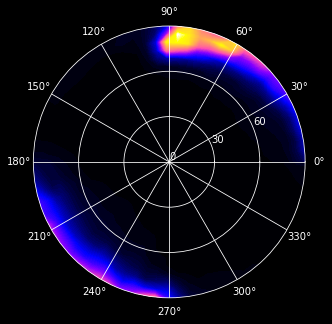

In [28]:
# 3D orientation histograms for the structure and permittivity tensor

mask = np.abs(ret_crop[0].copy())
mask[mask < 0.0006] = 0
mask[mask >= 0.0006] = 1

az = azimuth_crop.flatten()
th = theta_crop.flatten()
val = np.abs(ret_crop * mask).flatten()
wo.orientation_3D_hist(
    az, th, val, bins=36, num_col=1, size=5, contour_level=100, hist_cmap="gnuplot2", top_hemi=True, colorbar=False
)

## Load H&E data

In [29]:
# Load the H&E data and background (for white balancing)
HE_path = "/gpfs/CompMicro/rawdata/falcon/LiHao/20210317_Falcon_3D_PTI_realign_H_and_E_770nm/smooth_muscle_2/fluor/"
HE_bg_path = (
    "/gpfs/CompMicro/rawdata/falcon/LiHao/20210317_Falcon_3D_PTI_realign_H_and_E_770nm/smooth_muscle_1/fluor_bg/"
)
files_HE = sorted(glob.glob(HE_path + "img*.tif"), key=wo.numericalSort)
files_HE_bg = sorted(glob.glob(HE_bg_path + "img*.tif"), key=wo.numericalSort)
N_channel_HE = 3

I_HE = np.zeros((N_channel_HE, N_full, M_full, N_defocus))
I_HE_bg = np.zeros((N_channel_HE, N_full, M_full))

for i in range(N_channel_HE):
    image_temp = plt.imread(files_HE_bg[i]).astype("float64")
    for ll in range(4):
        I_HE_bg[i, :, :] += image_temp[start_idx[ll][0] :: 2, start_idx[ll][1] :: 2] / 4
    for j in range(N_defocus):
        idx = i * N_defocus + j
        image_temp = plt.imread(files_HE[idx]).astype("float64")
        for ll in range(4):
            I_HE[i, :, :, j] += image_temp[start_idx[ll][0] :: 2, start_idx[ll][1] :: 2] / 4

I_HE = I_HE[:, :, :, ::-1]

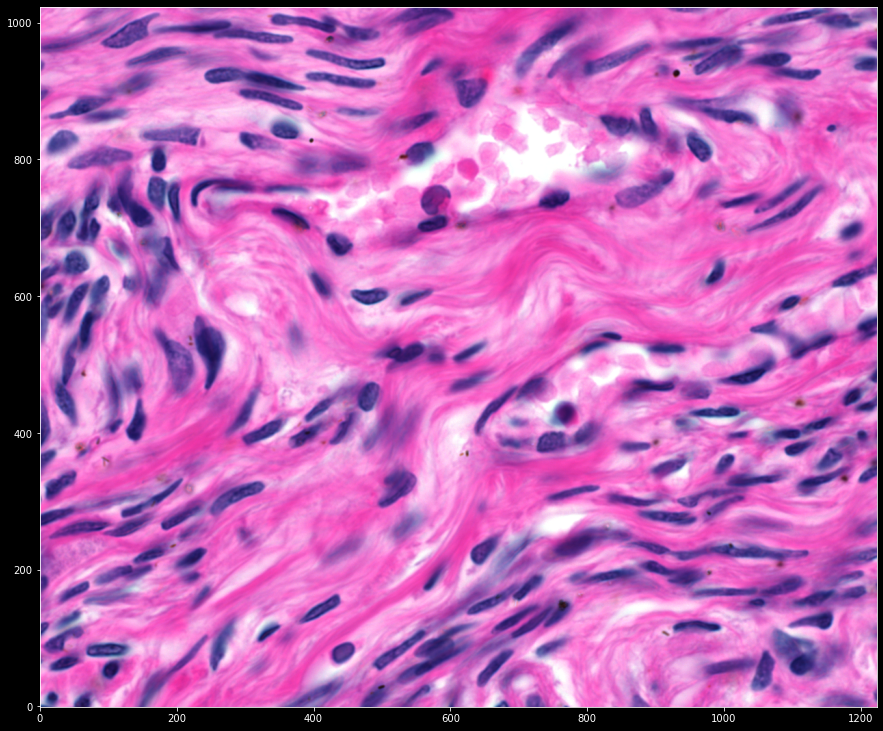

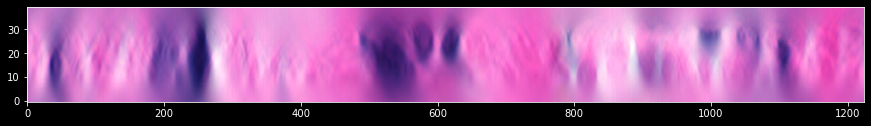

In [30]:
# White balancing

I_HE_norm = np.transpose(np.clip(I_HE / I_HE_bg[:, :, :, np.newaxis], 0, 1), (3, 1, 2, 0))
I_HE_norm[:, :, :, 0] = np.clip(I_HE_norm[:, :, :, 0] / 0.96786864, 0, 1)
I_HE_norm[:, :, :, 1] = np.clip(I_HE_norm[:, :, :, 1] / 0.80328606, 0, 1)
I_HE_norm[:, :, :, 2] = np.clip(I_HE_norm[:, :, :, 2] / 0.93734105, 0, 1)

plt.figure(figsize=(15, 15))
plt.imshow(I_HE_norm[z_layer], origin="lower")
plt.figure(figsize=(15, 15))
plt.imshow(I_HE_norm[:, y_layer], origin="lower", aspect=z_step / ps)

In [31]:
# save results to zarr array
writer = WaveorderWriter(output_path, hcs=False, hcs_meta=None, verbose=True)
writer.create_zarr_root("H_and_E.zarr")

position = 0
chan_names_HE = ["Red", "Green", "Blue"]
HE_data_array = np.transpose(I_HE_norm, (3, 0, 1, 2))[np.newaxis, ...]
data_shape_HE = phys_data_array.shape
chunk_size_HE = (1, 1, 1) + HE_data_array.shape[3:]
dtype = "float32"
writer.init_array(position, data_shape_HE, chunk_size_HE, chan_names_HE, dtype, position_name="H_and_E", overwrite=True)
writer.write(HE_data_array, p=position)

Creating new zarr store at Full_FOV_process_test_new_pipeline/H_and_E.zarr
Creating and opening subgroup Row_0/Col_0/H_and_E
Opening subgroup Row_0/Col_0/H_and_E
